# Model Single EEG channel Eye Blink Detector

EEG recordings are often contaminated by eye blink artifacts. When there are >25 channels (sensors), we can use techniques like Independent Component Analysis (ICA) to extract components which have eye blinks. However, this can be incredibly difficult when only a single channel is available for recording, specially if the channel is much further away from the forehead (proximity).

Here I present a semi supervised method to detect/classify epochs of data contaminated by eye blink artifacts from a single channel: Cz, that is located centrally.

Data available: 25 channels, 5 min data for 19 subjects, minimally preprocessed

File Aim: Develop ml semisupervised model for eye blink classification

Steps:
1. Create waveform statistical features to be used for data analysis from all the training and validation datasets
2. Use PCA to reduce dimensions
3. Run K means in unsupervised method and assign labels based on labeled training sets

2 methods:
1. kmeans: waveform statistical features
2. kmeans: pca from features

(Also tried kmeans: dynamic time warping with raw time series -> but since Raw time series takes too long, could not test with my computing power)


In [1]:
# import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ml_model_helper import create_waveform_features, map_true_predicted_labels

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# from dtaidistance import dtw
# from tslearn.clustering import TimeSeriesKMeans

Load training and validation datasets
(converted back to numpy array from saved dataframe due to signal processing ease on numpy arrays)

In [2]:
sampling_freq = 256  # Sampling frequencies

# Load dataframes, convert back to numpy for simpler feature generation
Cz_X_train_unlabeled = pd.read_csv(
    r"Data\Cz_X_train_unlabeled_df.csv", header=0
).to_numpy()  # unlabeled training set: unsupervised
Cz_X_train_labeled = pd.read_csv(
    r"Data\Cz_X_train_labeled_df.csv", header=0
).to_numpy()  # supervised training set: labeled
Cz_X_val = pd.read_csv(
    r"Data\Cz_X_val_df.csv", header=0
).to_numpy()  # labeled validation set

Cz_y_train_labeled = (
    pd.read_csv(r"Data\Cz_y_train_labeled_df.csv", header=0).to_numpy().ravel()
)  # labels for supervised training
Cz_y_val = (
    pd.read_csv(r"Data\Cz_y_val_df.csv", header=0).to_numpy().ravel()
)  # labels for validation
print(Cz_y_train_labeled.shape)

Cz_X_train = np.append(
    Cz_X_train_labeled, Cz_X_train_unlabeled, axis=0
)  # combine all training features
print(Cz_X_train.shape)

(1800,)
(7800, 128)


Extracting features from the time series epochs (0.5 secs each):
'mean', 'median', 'std', 'variance', 'skew', 'kurtosis', 'Range', 'maxPeakWidth', 'maxTroughWidth', 'lfPower', 'hfPower', 'HjorthMobility', 'HjorthComplexity'

These features can help define wave characteristics


In [3]:
# ml helper function to create the features
[feature_names, Cz_X_train_unlabeled_features] = create_waveform_features(
    Cz_X_train_unlabeled, sampling_freq
)
[feature_names, Cz_X_train_labeled_features] = create_waveform_features(
    Cz_X_train_labeled, sampling_freq
)

# combine entire training set (include both unlabeled and labeled sets)
Cz_X_train_features = np.append(
    Cz_X_train_labeled_features, Cz_X_train_unlabeled_features, axis=0
)
print(Cz_X_train_features.shape)
print(feature_names)

(7800, 13)
['mean', 'median', 'std', 'variance', 'skew', 'kurtosis', 'amplitude_range', 'max_peak_width', 'max_trough_width', 'low_freq_power', 'high_freq_power', 'Hjorth_mobility', 'Hjorth_complexity']


Run PCA on these features to transform and reduce dimensionality into principal components
1. Scale all features
2. Run PCA
3. Visualize and choose number of PCs based on explained variance
(trial and error revealed n_components = 2 to be sufficient)

In [4]:
feature_scaler = StandardScaler().fit(Cz_X_train_features)
scaled_Cz_X_train = feature_scaler.transform(Cz_X_train_features)

pca_all_comp = PCA()
pca_all_comp.fit(scaled_Cz_X_train)

explained_variance = pca_all_comp.explained_variance_ratio_
print(explained_variance)  # n_components = 2 explains ~50% variance

[0.34241645 0.18950257 0.14077648 0.08282585 0.07180431 0.0524581
 0.04743062 0.03249457 0.01527087 0.01295339 0.00871316 0.0024308
 0.00092282]


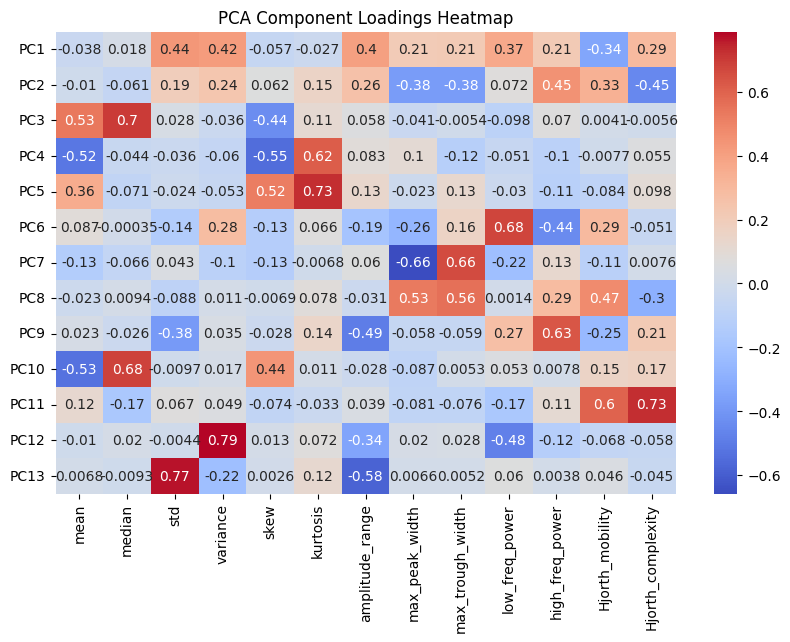

In [5]:
loadings = pd.DataFrame(
    pca_all_comp.components_,
    columns=feature_names,
    index=[f"PC{i+1}" for i in range(pca_all_comp.n_components_)],
)

plt.figure(figsize=(10, 6))
sns.heatmap(loadings, cmap="coolwarm", annot=True)
plt.title("PCA Component Loadings Heatmap")
plt.show()

Run PCA and extract pc1 and pc2

In [6]:
# pca on training data
pca_trained = PCA(n_components=2, random_state=8)

# transform training data
Cz_X_train_PC = pca_trained.fit_transform(scaled_Cz_X_train)

# separate labeled and unlabeled
Cz_X_train_labeled_PC = Cz_X_train_PC[0:1800, :]
Cz_X_train_unlabeled_PC = Cz_X_train_PC[1800:, :]

## Semi Supervised Modeling

While the dataset is currently imbalanced, kmeans does not perform too badly with this. We can choose to balance the training model for other approaches or for better tuning.

### Kmeans: 13 waveform features

Method 1: Run the K means on extracted features (non-PCA)

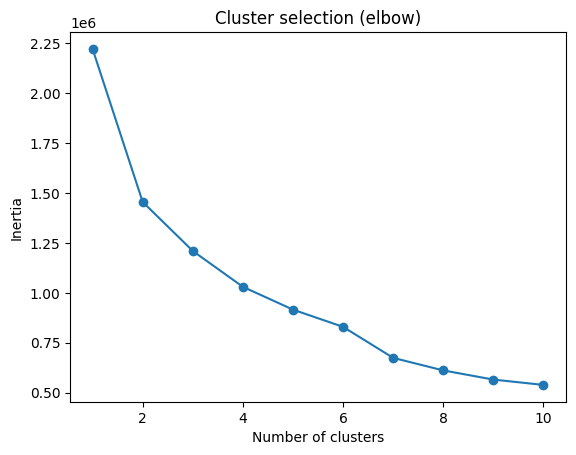

In [7]:
# Test feature kmeans and visualize number of clusters using elbow method
inertias = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=8)
    kmeans.fit(Cz_X_train_features)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, marker="o")
plt.title("Cluster selection (elbow)")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

Cluster-label-mapped accuracy: 0.692
[[ 8.32032967e-03  2.12775544e-02  1.96723319e+00  4.48996436e+00
  -1.95743775e-02 -1.98544146e-01  9.00325447e+00  1.57304183e+01
   1.57522814e+01  1.12566934e+00  1.09032823e+00  3.66082646e-01
   1.94983738e+00]
 [-1.63891214e-02  4.13005993e-02  2.39281618e+00  6.61881140e+00
  -7.11614472e-02 -3.65835651e-01  1.03192909e+01  3.07594488e+01
   3.02937008e+01  2.92767743e+00  7.03280236e-01  2.80009790e-01
   2.60357867e+00]]


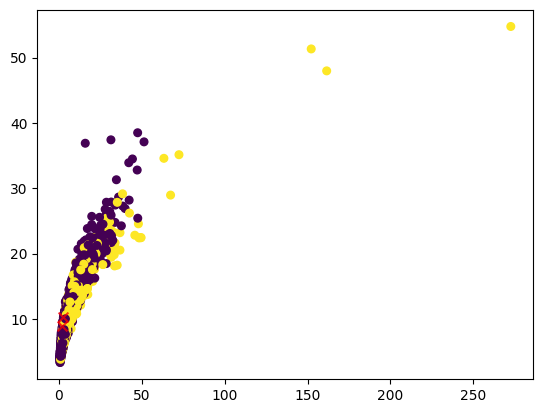

In [8]:
kmeans_features = KMeans(n_clusters=2, random_state=8)
kmeans_features.fit(Cz_X_train_features)

Cz_y_train_labeled_pred_features = kmeans_features.predict(Cz_X_train_labeled_features)

[true_label_mapping_features, mapping_accuracy_features, _, _, _] = (
    map_true_predicted_labels(Cz_y_train_labeled, Cz_y_train_labeled_pred_features)
)

Cz_y_train_labeled_mapped_pred_features = np.vectorize(true_label_mapping_features.get)(
    Cz_y_train_labeled
).flatten()

# 6. Evaluate mapped clustering as classification predictions
print(f"Cluster-label-mapped accuracy: {mapping_accuracy_features:.3f}")

centroids = kmeans_features.cluster_centers_
print(centroids)
plt.scatter(
    Cz_X_train_features[:, 3],
    Cz_X_train_features[:, 6],
    c=kmeans_features.labels_,
    s=30,
)
plt.scatter(centroids[:, 2], centroids[:, 6], c="red", s=50, alpha=0.75, marker="x")

plt.show()

### Kmeans: PCA features

Method 2: Run the K means on 2 PCA components

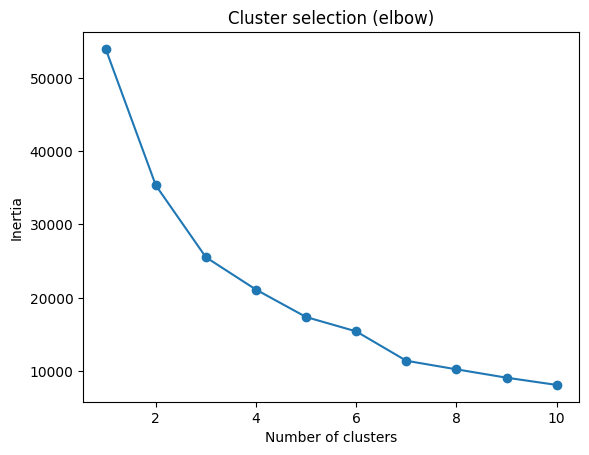

In [9]:
# Test PCA kmeans using elbow method
inertias = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=8)
    kmeans.fit(Cz_X_train_PC)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, marker="o")
plt.title("Cluster selection (elbow)")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

Cluster-label-mapped accuracy: 0.802
[[-1.02044448  0.18537136]
 [ 2.26180992 -0.41087465]]


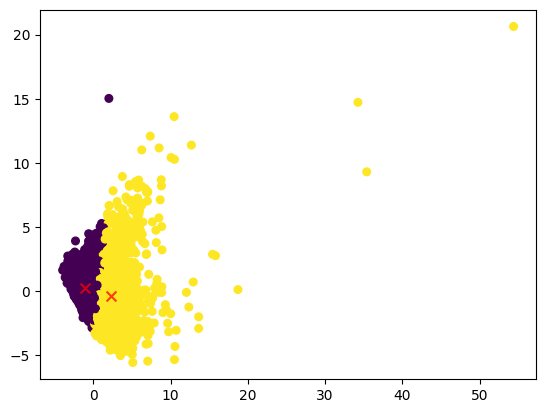

In [10]:
kmeans_PC = KMeans(n_clusters=2, random_state=8)
kmeans_PC.fit(Cz_X_train_PC)

Cz_y_train_labeled_pred_PC = kmeans_PC.predict(Cz_X_train_labeled_PC)

[true_label_mapping_PC, mapping_accuracy_PC, _, _, _] = map_true_predicted_labels(
    Cz_y_train_labeled, Cz_y_train_labeled_pred_PC
)

Cz_y_train_labeled_mapped_pred_PC = np.vectorize(true_label_mapping_PC.get)(
    Cz_y_train_labeled_pred_PC
).flatten()

# 6. Evaluate mapped clustering as classification predictions
print(f"Cluster-label-mapped accuracy: {mapping_accuracy_PC:.3f}")

centroids = kmeans_PC.cluster_centers_
print(centroids)

plt.scatter(Cz_X_train_PC[:, 0], Cz_X_train_PC[:, 1], c=kmeans_PC.labels_, s=30)
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", s=50, alpha=0.75, marker="x")

plt.show()

### Accuracy of PCA transformed predictions is better than that of waveform features

Visually test how the predictions look in timeseries format for unlabeled data

In [11]:
Cz_y_train_unlabeled_pred_PC = kmeans_PC.predict(Cz_X_train_unlabeled_PC)
Cz_y_train_unlabeled_mapped_pred_PC = np.vectorize(true_label_mapping_PC.get)(
    Cz_y_train_unlabeled_pred_PC
).reshape(Cz_y_train_unlabeled_pred_PC.shape[0], 1)

print(Cz_y_train_unlabeled_mapped_pred_PC.shape)
print(Cz_X_train_unlabeled.shape)
print(Cz_y_train_unlabeled_mapped_pred_PC)
Cz_y_train_unlabeled_mapped_pred_PC_repeated = np.tile(
    Cz_y_train_unlabeled_mapped_pred_PC, (1, 128)
)
print(Cz_y_train_unlabeled_mapped_pred_PC_repeated)

Cz_X_train_unlabeled_joined = Cz_X_train_unlabeled.reshape(-1)
Cz_y_train_unlabeled_mapped_pred_PC_joined = (
    Cz_y_train_unlabeled_mapped_pred_PC_repeated.reshape(-1)
)
print(Cz_X_train_unlabeled_joined.shape)
print(Cz_y_train_unlabeled_mapped_pred_PC_joined.shape)

(6000, 1)
(6000, 128)
[[0]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0 0 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(768000,)
(768000,)


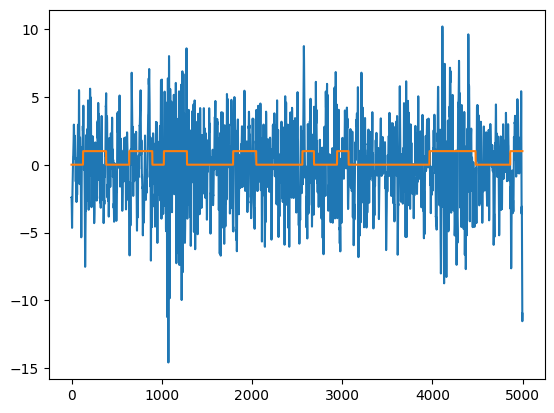

In [12]:
timePts = 5000

timeSec = np.arange(timePts) * (1 / sampling_freq)
Cz_X_train_unlabeled_joined_df = pd.DataFrame(
    {
        "time": timeSec,
        "value": Cz_X_train_unlabeled_joined[:timePts],
        "mapped_label": Cz_y_train_unlabeled_mapped_pred_PC_joined[:timePts],
    }
)

# sns.lineplot(data=Cz_X_train_unlabeled_joined_df,x= 'time', y='value')
# sns.lineplot(data=Cz_X_train_unlabeled_joined_df,x= 'time', y='mapped_label')
plt.plot(Cz_X_train_unlabeled_joined[:timePts])
plt.plot(Cz_y_train_unlabeled_mapped_pred_PC_joined[:timePts])

### Dynamic Time warping
Testing unsuccessful due to limited computing power

In [13]:
# # 128 features (each data point) Takes too long
# tskmeans = TimeSeriesKMeans(n_clusters=2, metric="dtw", random_state=8)
# # Fit the model
# tskmeans.fit(Cz_X_train)

## Validation Test with K means PC model

In [14]:
[feature_names, Cz_X_val_features] = create_waveform_features(Cz_X_val, sampling_freq)
Cz_X_val_scaled = feature_scaler.transform(Cz_X_val_features)
Cz_X_val_PC = pca_trained.transform(Cz_X_val_scaled)

Cz_X_val_predictions = kmeans_PC.predict(Cz_X_val_PC)
Cz_y_val_mapped_pred_PC = (
    np.vectorize(true_label_mapping_PC.get)(Cz_X_val_predictions)
    .reshape(Cz_X_val_predictions.shape[0], 1)
    .flatten()
)

print("Accuracy: {:.3f}".format(accuracy_score(Cz_y_val, Cz_y_val_mapped_pred_PC)))
print(
    "F1 score:",
    [
        "{:.3f}".format(x)
        for x in f1_score(Cz_y_val, Cz_y_val_mapped_pred_PC, average=None)
    ],
)
print(
    "Precision:",
    [
        "{:.3f}".format(x)
        for x in precision_score(Cz_y_val, Cz_y_val_mapped_pred_PC, average=None)
    ],
)
print(
    "Recall:",
    [
        "{:.3f}".format(x)
        for x in recall_score(Cz_y_val, Cz_y_val_mapped_pred_PC, average=None)
    ],
)

Accuracy: 0.842
F1 score: ['0.892', '0.706']
Precision: ['0.930', '0.635']
Recall: ['0.857', '0.795']


[[1175  196]
 [  88  341]]


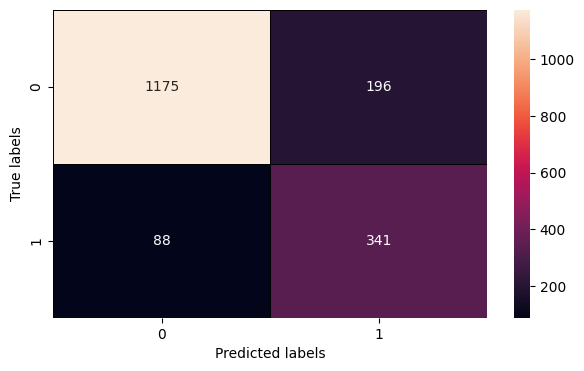

In [15]:
confusion_mat_val = confusion_matrix(Cz_y_val, Cz_y_val_mapped_pred_PC)
print(confusion_mat_val)

plt.figure(figsize=(7, 4))
sns.heatmap(confusion_mat_val, annot=True, fmt="d", linewidths=0.5, linecolor="black")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()